## Import libraries

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from itertools import zip_longest

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn import metrics
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## Load the data

This dataset comes from the Housing Data Set from Ames, IA. The data documentation may be found [here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt).

In [230]:
sample = pd.read_csv('../datasets/sample_sub_reg.csv')
df = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

## Data cleaning: Initial check

In [231]:
df.shape

(2051, 81)

In [232]:
test.shape

(878, 80)

In [233]:
df.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000


In [234]:
datatypes = df.dtypes
object_cols = datatypes.pipe(lambda x: x.index[x=='object'])

for d in datatypes.unique():
    print(f"{d} dtype columns: \n {(datatypes.index[datatypes==d].tolist())}\n")

int64 dtype columns: 
 ['Id', 'PID', 'MS SubClass', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice']

object dtype columns: 
 ['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Po

## Data cleaning: Float columns

In [235]:
df.select_dtypes(include='float64').describe()

,Lot Frontage,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Garage Yr Blt,Garage Cars,Garage Area
count,1721.000000,2029.000000,2050.000000,2050.000000,2050.000000,2050.000000,2049.000000,2049.000000,1937.000000,2050.000000,2050.000000
mean,69.055200,99.695909,442.300488,47.959024,567.728293,1057.987805,0.427526,0.063446,1978.707796,1.776585,473.671707
std,23.260653,174.963129,461.204124,165.000901,444.954786,449.410704,0.522673,0.251705,25.441094,0.764537,215.934561
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1895.000000,0.000000,0.000000
25%,58.000000,0.000000,0.000000,0.000000,220.000000,793.000000,0.000000,0.000000,1961.000000,1.000000,319.000000
50%,68.000000,0.000000,368.000000,0.000000,474.500000,994.500000,0.000000,0.000000,1980.000000,2.000000,480.000000
75%,80.000000,161.000000,733.750000,0.000000,811.000000,1318.750000,1.000000,0.000000,2002.000000,2.000000,576.000000
max,313.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,3.000000,2.000000,2207.000000,5.000000,1418.000000


The [data documentation](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) says that `Total Bsmt SF` is the total square feet of basement area and all other `Bsmt` columns are areas of different types of basements; so the total should equal the sum of those areas. A sanity checks shows that that is indeed true. The only row where it's not true is the row where all basement values are missing.

There are some columns (number of bathrooms in the basement, year, size of garage in car capacity) that should be integer columns but due to missing values are float. A simple check shows that that's true.

There is a single `Garage Yr Built` that is 2207 (since the data covers until 2010), I clip it at 2010.

In [236]:
def clean_floats(df):
    
    s1 = df[df['Total Bsmt SF'] != df.filter(regex='^Bsmt.*SF.*').sum(1)].filter(like='Bsmt')
    if not (s1.empty or s1.isna().all().all()):
        raise ValueError("Bsmt SF does not add up.")
        
    s2 = df[['Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt', 'Garage Cars']].stack()
    if not s2.astype(int).eq(s2).all():
        raise ValueError("There are non-integer values where it should be integer.")
        
    df['Garage Yr Blt'] = df['Garage Yr Blt'].clip(upper=2010)
    return df

## Data cleaning: Integer columns

In [237]:
df.select_dtypes(include='int64').describe()

,Id,PID,MS SubClass,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,1st Flr SF,2nd Flr SF,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2051.000000,2.051000e+03,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,...,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,10065.208191,6.112140,5.562165,1971.708922,1984.190151,1164.488055,329.329108,...,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,1.886918e+08,42.824223,6742.488909,1.426271,1.104497,30.177889,21.036250,396.446923,425.671046,...,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,5.263011e+08,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,334.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,5.284581e+08,20.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,879.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,5.354532e+08,50.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,1093.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,9.071801e+08,70.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,1405.000000,692.500000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,5095.000000,1862.000000,...,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


Above ground living area (`Gr Liv Area`) must be the sum of the areas of all floors and the low quality finished square feet (`Low Qual Fin SF`). I check if that is the case.

Remodel date (`Year Remod/Add`) cannot be later than `Year Built`, so I make sure that is true.

In [238]:
def clean_ints(df):
    
    if not df.filter(regex='.* Flr|Fin SF$').sum(1).eq(df['Gr Liv Area']).all():
        raise ValueError("Gr Liv Area does not add up.")
        
    df['Year Built'] = df['Year Remod/Add'].mask(df.eval("`Year Built` > `Year Remod/Add`"), df['Year Built'])
    
    return df

## Data cleaning: Data type mismatch

Reading the [data documentation](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) a little closely,

- `MS SubClass` identifies the type of dwelling involved in the sale and is a nominal value, so it should be `string` dtype
- `Overall Qual` rates the overall material and finish of the house and is an ordinal value, so it should be `Categorical` dtype
- `Overall Cond` rates the overall condition of the house and is an ordinal value; so it should be `Categorical`.
- All date time features are also converted to Categorical dtype.

In [239]:
def fix_dtypes(df):
    
    df['MS SubClass'] = df['MS SubClass'].astype(str).str.zfill(3)
    df[cat_cols] = df[cat_cols].astype(str)
#     for c in cat_cols:
#         df[c] = pd.Categorical(df[c], ordered=True)
    
    return df

## Data cleaning: Missing values

In [240]:
cols_with_missing_vals = df.loc[:, df.isna().any()]

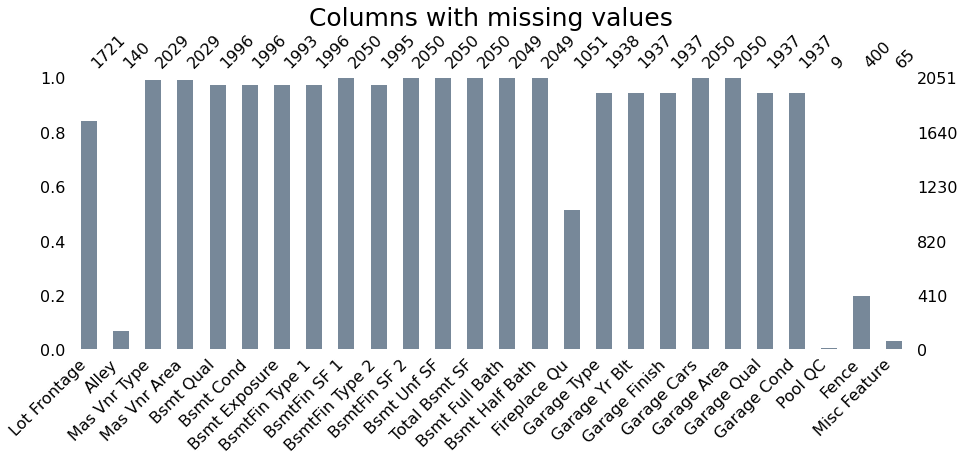

In [241]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
msno.bar(cols_with_missing_vals, figsize=(12,5), color='lightslategray', ax=ax)
ax.set_title("Columns with missing values", fontsize=25);

Let's look at the non-numeric columns a little closely.

In [242]:
with pd.option_context('display.max_colwidth', None):
    print(cols_with_missing_vals.select_dtypes(exclude='number').apply(lambda x: x.unique()))

Alley                                                    [nan, Pave, Grvl]
Mas Vnr Type                           [BrkFace, None, nan, Stone, BrkCmn]
Bsmt Qual                                        [TA, Gd, Fa, nan, Ex, Po]
Bsmt Cond                                        [TA, Gd, nan, Fa, Po, Ex]
Bsmt Exposure                                        [No, Gd, Av, nan, Mn]
BsmtFin Type 1                         [GLQ, Unf, ALQ, Rec, nan, BLQ, LwQ]
BsmtFin Type 2                         [Unf, Rec, nan, BLQ, GLQ, LwQ, ALQ]
Fireplace Qu                                     [nan, TA, Gd, Po, Ex, Fa]
Garage Type       [Attchd, Detchd, BuiltIn, Basment, nan, 2Types, CarPort]
Garage Finish                                         [RFn, Unf, Fin, nan]
Garage Qual                                      [TA, Fa, nan, Gd, Ex, Po]
Garage Cond                                      [TA, Fa, nan, Po, Gd, Ex]
Pool QC                                              [nan, Fa, Gd, Ex, TA]
Fence                    

For the non-numeric columns missing values, the [data documentation](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) explains that the missing value NaN is actually a legitimate value for these columns; it indicates that it's simply not available. For example, `Alley` is a column indicating the type of alley access to property; if a house doesn't have alley access, there is no value.

Some of these columns have accompanying numeric column as well. For example, `Mas Vnr Type` (masonry veneer type) has an accompanying numeric column, `Mas Vnr Area`. Let's investigate it a little further. Below, I group the column names with missing values by the number of missing values.

In [243]:
with pd.option_context('display.max_colwidth', None):
    print(cols_with_missing_vals.columns.to_series().groupby(cols_with_missing_vals.isna().sum()).agg(list))

1       [BsmtFin SF 1, BsmtFin SF 2, Bsmt Unf SF, Total Bsmt SF, Garage Cars, Garage Area]
2                                                         [Bsmt Full Bath, Bsmt Half Bath]
22                                                            [Mas Vnr Type, Mas Vnr Area]
55                                                  [Bsmt Qual, Bsmt Cond, BsmtFin Type 1]
56                                                                        [BsmtFin Type 2]
58                                                                         [Bsmt Exposure]
113                                                                          [Garage Type]
114                               [Garage Yr Blt, Garage Finish, Garage Qual, Garage Cond]
330                                                                         [Lot Frontage]
1000                                                                        [Fireplace Qu]
1651                                                                               [Fence]

Looking at these columns, we can divide them into 4 groups:

- `Bsmt` columns: `BsmtFin SF 1`, `Bsmt Full Bath`, `Bsmt Exposure` etc.
- `Garage` columns: `Garage Cars`, `Garage Type`, `Garage Cond` etc.
- `Mas Vnr` columns: `Mas Vnr Type`, `Mas Vnr Area`
- Others: `Lot Frontage`, `Fireplace Qu` etc.

Also, it seems the features with two columns (e.g. `Mas Vnr Type` and `Mas Vnr Area`) have equal number of missing values.

In [244]:
def flag_na_rows(df):
    return df['Bsmt Cond'].isna(), df['Garage Cond'].isna(), df['Mas Vnr Type'].isna()

bsmt_cols = [c for c in df.columns if 'Bsmt' in c]
garage_cols = [c for c in df.columns if 'Garage' in c]
mas_vnr_cols = [c for c in df.columns if 'Mas Vnr' in c]
other_cols = ['Lot Frontage', 'Fireplace Qu', 'Fence', 'Alley', 'Misc Feature', 'Pool QC']

bsmt_cond_na, garage_type_na, mas_vnr_type_na = flag_na_rows(df)

print("If `Bsmt Cond` is missing a value, all other `Bsmt` columns are either missing a value or has a value equal to 0:",
      df.loc[bsmt_cond_na, bsmt_cols].pipe(lambda x: x.isna() | x.eq(0)).all().all())

print("If `Garage Type` is missing a value, all other Garage columns are either missing a value or has a value equal to 0:",
      df.loc[garage_type_na, garage_cols].pipe(lambda x: x[(x.ne(0) & x.notna()).any(1)]).empty)

print("If `Mas Vnr Type` is missing a value, all other `Mas Vnr` columns are missing a value:",
      df.loc[mas_vnr_type_na, mas_vnr_cols].isna().all().all())

If `Bsmt Cond` is missing a value, all other `Bsmt` columns are either missing a value or has a value equal to 0: True
If `Garage Type` is missing a value, all other Garage columns are either missing a value or has a value equal to 0: False
If `Mas Vnr Type` is missing a value, all other `Mas Vnr` columns are missing a value: True


Given the observation above, I replace in the missing numeric columns by 0 and missing ordinal columns by `'NA'` strings.

After this operation, 4 rows with missing `Bsmt` value remains. Upon closer inspection, they are columns where one `BsmtFin Type` has value but the other is missing value or the basement is unfinished, so the exposure is missing a value. I fill these missing values by `'NA'` strings, since it's a legitimate value.

In [245]:
def clean_df(df):
    
    df = clean_floats(df)
    df = clean_ints(df)
    df = fix_dtypes(df)
    
    misc_empty = df.query("`Misc Feature`.isna().values and `Misc Val` != 0").empty 
    pool_empty = df.query("`Pool QC`.isna().values and `Pool Area` != 0").empty
    fireplace_empty = df.query("`Fireplace Qu`.isna().values and Fireplaces != 0").empty
    
    if not misc_empty:
        raise ValueError("A missing miscellaneous feature has a nonzero value.")
    if not pool_empty:
        raise ValueError("A missing pool quality has a nonzero accompanying pool area.")
    if not fireplace_empty:
        raise ValueError("A missing fireplace quality has a nonzero number of accompanying fireplaces.")
    
    bsmt_cond_na, garage_type_na, mas_vnr_type_na = flag_na_rows(df)
    
    df.loc[bsmt_cond_na, [c for c in bsmt_cols if c in object_cols]] = 'NA'
    df.loc[bsmt_cond_na, [c for c in bsmt_cols if c not in object_cols]] = 0

    df.loc[garage_type_na, [c for c in garage_cols if c in object_cols]] = 'NA'
    df.loc[garage_type_na, [c for c in garage_cols if c not in object_cols and c != 'Garage Yr Blt']] = 0

    df.loc[mas_vnr_type_na, [c for c in mas_vnr_cols if c in object_cols]] = 'NA'
    df.loc[mas_vnr_type_na, [c for c in mas_vnr_cols if c not in object_cols]] = 0

    obj_other_cols = [c for c in other_cols if c in object_cols]
    df[obj_other_cols] = df[obj_other_cols].fillna('NA')
    
    df[bsmt_cols] = df[bsmt_cols].fillna('NA')
    
    return df

In [246]:
object_cols = object_cols.tolist() + ['MS SubClass']
cat_cols = ['Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Yr Sold', 'Mo Sold']

df = clean_df(df)
test = clean_df(test)

After the above cleaning, there remains 2 columns with missing values. The year garage was built (`Garage Yr Blt`) is missing for houses that don't have garages. The below function checks if any garages have the year it was built missing from the dataset. It turns out, every existing garage has its built year in the dataset.

In [247]:
def garage_yr_cond(df):
    if not df.query("`Garage Yr Blt`.isna().values and `Garage Cond` != 'NA'").empty:
        raise ValueError("There are existing garages whose year built is missing.")

garage_yr_cond(df)
garage_yr_cond(test)

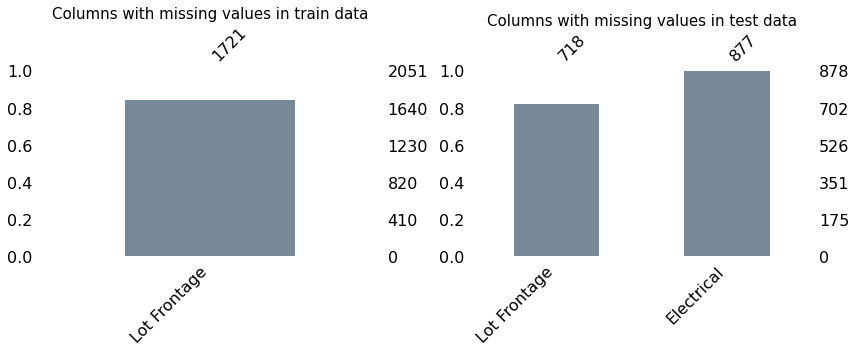

In [248]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
msno.bar(df.loc[:, df.isna().any()], figsize=(6,5), color='lightslategray', ax=axs[0])
axs[0].set_title("Columns with missing values in train data", fontsize=15)
msno.bar(test.loc[:, test.isna().any()], figsize=(6,5), color='lightslategray', ax=axs[1])
axs[1].set_title("Columns with missing values in test data", fontsize=15)
fig.tight_layout();

### Data cleaning: Missing value 1 - Garage Yr Built

There are 3 "year built" columns and judging from the scatter plot below, they are heavily correlated with one another, it suffices to keep only one of them. Since there are no missing values from `Year Built`, I keep it and drop the others.

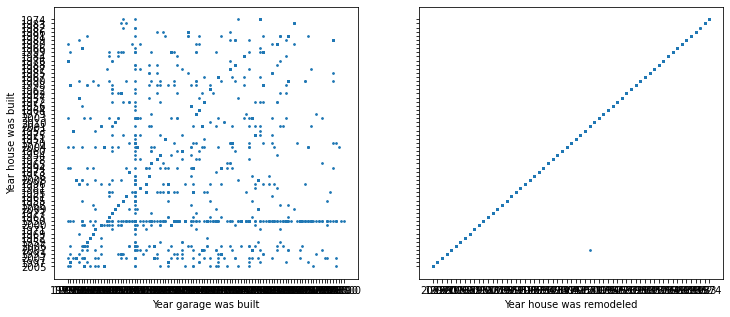

In [249]:
f, ax  = plt.subplots(1,2, figsize=(12,5), sharey=True)
ax[0].scatter(df['Garage Yr Blt'], df['Year Built'], s=3);
ax[0].set_xlabel("Year garage was built")
ax[0].set_ylabel("Year house was built")
ax[1].scatter(df['Year Remod/Add'], df['Year Built'], s=3);
ax[1].set_xlabel("Year house was remodeled");

### Data Cleaning: `Lot Frontage`

There are a lot of values missing in `Lot Frontage`. When we look at its histogram, there are sizable values with small values, so it doesn't exactly follow normal distribution. That being said, I will fill the missing values by the average `Lot Frontage`.

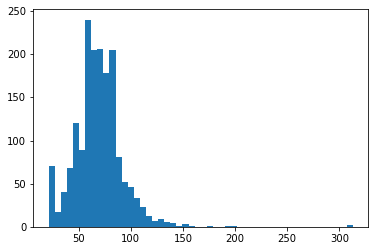

In [250]:
plt.hist(df['Lot Frontage'], bins=50);

## EDA: Heatmap of the correlation matrix

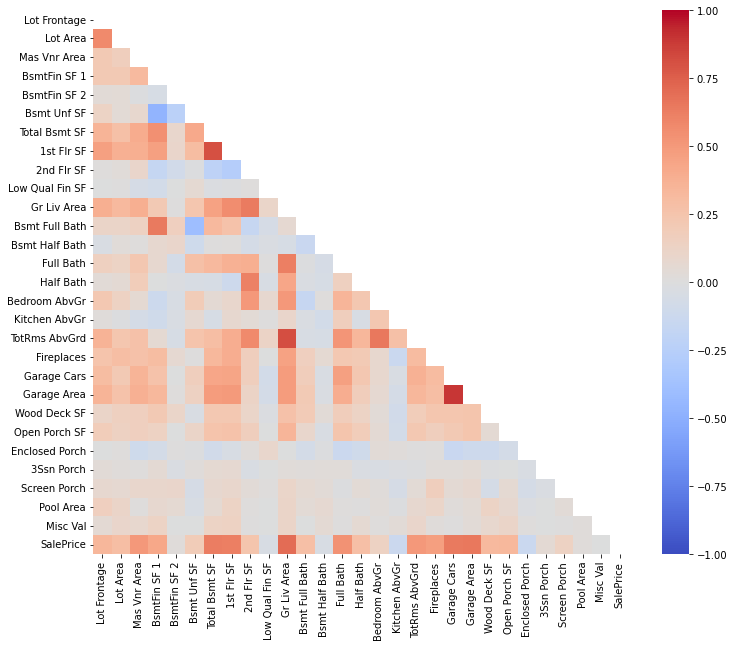

In [251]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
R = df.drop(columns=['Id', 'PID']).corr()
sns.heatmap(R, vmin=-1, vmax=1, cmap='coolwarm', mask=np.triu(R), ax=ax);

In [252]:
## EDA: Handling various Year columns
# f, ax = plt.subplots(2, figsize=(120,11))
# sns.boxplot(data=df, x='Garage Yr Blt', y='SalePrice', ax=ax[0])
# sns.boxplot(data=df, x='Year Built', y='SalePrice', ax=ax[1]); 
# df.groupby(df['Year Built'] > 1983)['SalePrice'].agg(['size', 'mean','median'])

# The above boxplot shows how sale price differs based on garage year built and the year the house was built. They show very similar pattern. This supports my dropping `Garage Yr Blt`. Another observation is that the price increase substantially since 1983. So I create a new binary feature: `Built After 1983` to flag if a house was built after 1983 or not.

In [253]:
# df['Built After 1983'] = df['Year Built'] > 1983

## EDA: Area columns vs `SalePrice`

In [254]:
# area columns as a new df
areas = df.filter(regex='Area|SF')

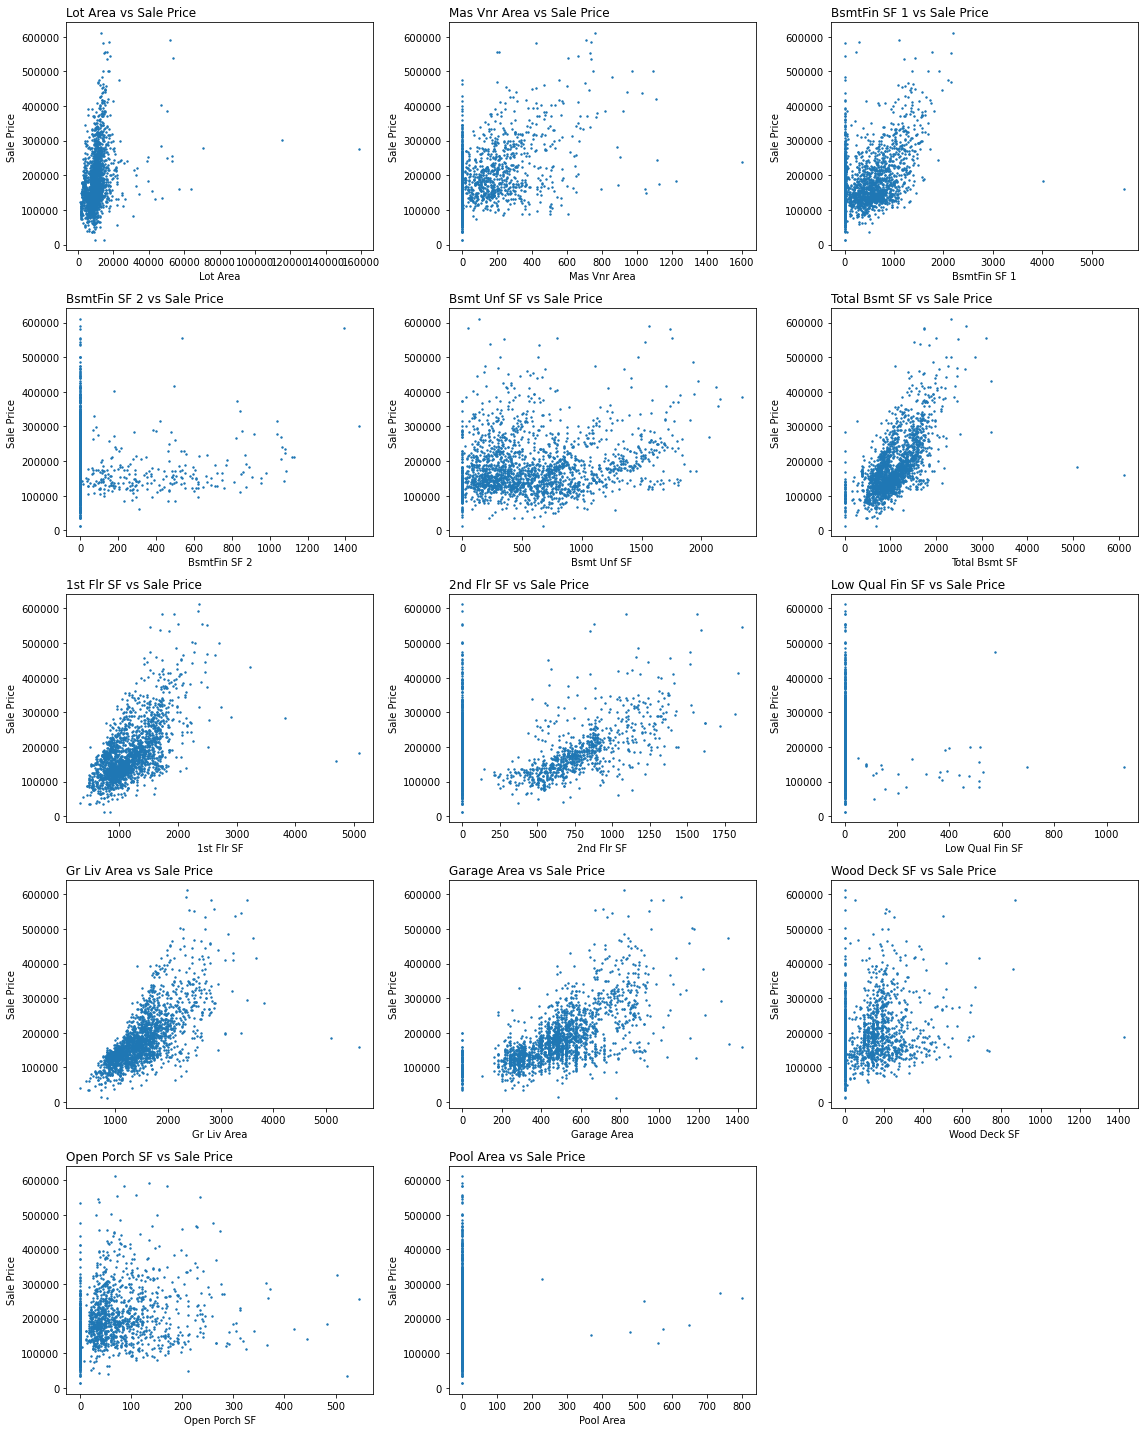

In [255]:
# compute the length of the plots
size = dr[0] + 1 if (dr := divmod(areas.shape[1], 3))[1] else dr[0]

# plot areas vs SalePrice
fig, axs = plt.subplots(size, 3, figsize=(16, 4*size))
for i, cs in enumerate(zip_longest(*[iter(areas)]*3)):
    for j, c in enumerate(cs):
        if c is not None:
            axs[i][j].scatter(areas[c], df['SalePrice'], s=2);
            axs[i][j].set_title(f'{c} vs Sale Price', fontsize=12, loc='left')
            axs[i][j].set_ylabel("Sale Price")
            axs[i][j].set_xlabel(f"{c}")
        else:
            axs[i][j].axis('off')
fig.tight_layout();

There are some dot to the right of the plots scattered out. That indicates that there are some outlier values. To curb the effect of outliers on the result, let's plot the log-log scatter plots.

There are some zero values which wouldn't work when we take log of them so, we add 1 to all columns so that taking a log always works.

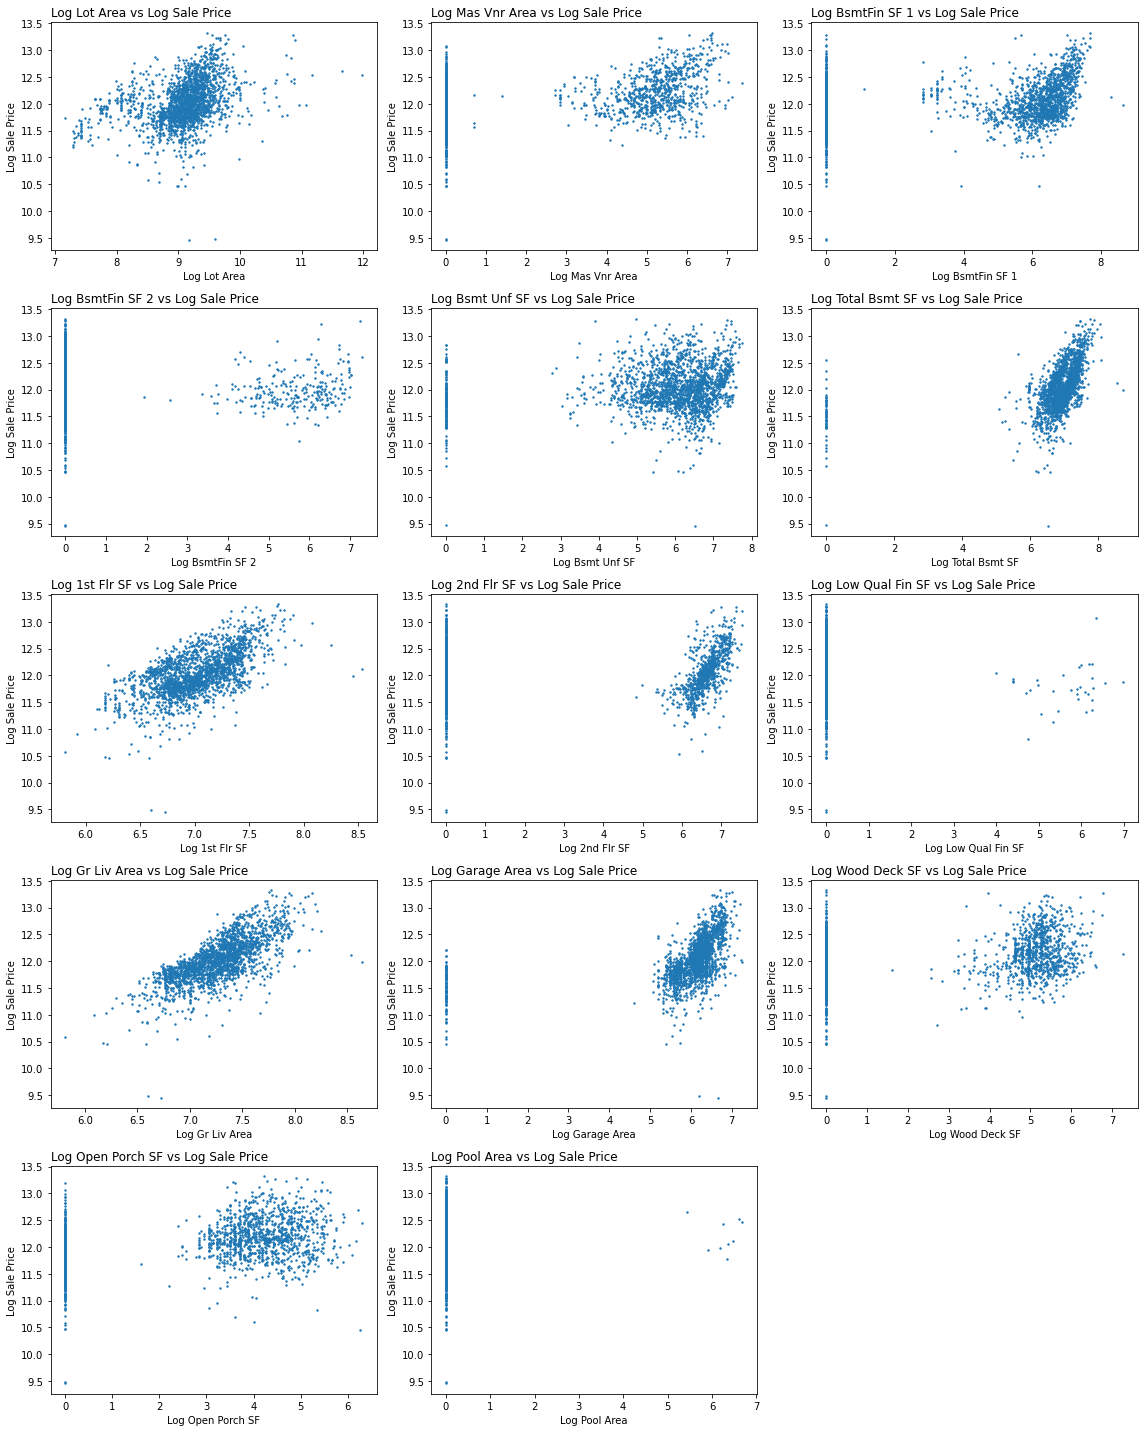

In [256]:
# plot area vs SalePrice
fig, axs = plt.subplots(size, 3, figsize=(16, 4*size))
for i, cs in enumerate(zip_longest(*[iter(areas)]*3)):
    for j, c in enumerate(cs):
        if c is not None:
            axs[i][j].scatter(np.log(areas[c] + 1), np.log(df['SalePrice'] + 1), s=2);
            axs[i][j].set_title(f'Log {c} vs Log Sale Price', fontsize=12, loc='left')
            axs[i][j].set_ylabel("Log Sale Price")
            axs[i][j].set_xlabel(f"Log {c}")
        else:
            axs[i][j].axis('off')
fig.tight_layout();

In [257]:
# sns.pairplot(df.filter(regex='Bsmt.*SF').add(1).apply(np.log), corner=True);

As we established in the **Data cleaning: Float columns** section, `Total Bsmt SF` is the sum of all `Bsmt SF` columns and `Gr Liv Area` is the sum of all above ground areas. So to combat heteroscedasticity, it might make sense to only drop some of them.

Moreover, some columns have very weak relationship with `SalePrice`; so those will be dropped as well.

In [258]:
area_cols_to_drop = ['1st Flr SF', 'Bsmt Unf SF', 'BsmtFin SF 2', 'Low Qual Fin SF', 
                     'Wood Deck SF', 'Pool Area', 'Lot Area']

In [259]:
X = areas.drop(columns=area_cols_to_drop).add_prefix('Log ').add(1).apply(np.log)
y = df[['SalePrice']].add(1).apply(np.log).add_prefix('Log ').squeeze()
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Log SalePrice   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     743.8
Date:                Fri, 14 Oct 2022   Prob (F-statistic):               0.00
Time:                        10:57:56   Log-Likelihood:                 211.20
No. Observations:                2051   AIC:                            -406.4
Df Residuals:                    2043   BIC:                            -361.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 5.2926      0.141     37.467      0.000       5.016       5.570
Log Mas Vnr Area      0.0169      0.002      8.149      0.000       0.013       0.021
Log BsmtFin SF 1      0.0165      0.002      9.360      0.000       0.013       0.020
Log Total Bsmt SF     0.0453      0.004     10.125      0.000       0.037       0.054
Log 2nd Flr SF       -0.0246      0.002    -13.523      0.000      -0.028      -0.021
Log Gr Liv Area       0.8336      0.021     39.859      0.000       0.793       0.875
Log Garage Area       0.0469      0.004     13.179      0.000       0.040       0.054
Log Open Porch SF     0.0278      0.003     11.101      0.000       0.023       0.033
==============================================================================
Omnibus:                      729.888   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6375.256
Skew:                          -1.424   Prob(JB):                         0.00
Kurtosis:                      11.154   Cond. No.                         388.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the log-log plots, `Log Total Bsmt SF`, `Log Gr Liv Area` and `Log Garage Area` show linear relationship with `Sale Price`. In particular, `Gr Liv Area` includes `Low Qual Fin SF` which has a weak relationship, so it might be better to just include the sum of the floor areas.

### EDA: `Porch` columns vs `SalePrice`

In [260]:
porch = df.filter(regex='Porch$')

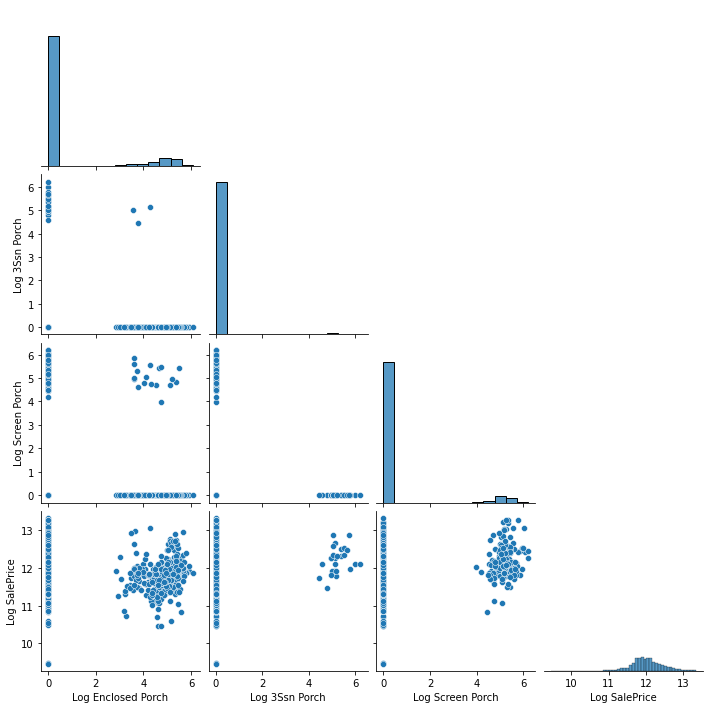

In [261]:
sns.pairplot(porch.assign(SalePrice=df['SalePrice']).add(1).add_prefix('Log ').apply(np.log), corner=True);

There's a very weak relationship between porch columns and `Log SalePrice` (and `SalePrice` as well), so they will be dropped.

### `Bath` columns vs `SalePrice`

In [262]:
bath = df.filter(like='Bath')

bath_cols = []
X = bath.drop(columns=bath_cols)
y = df[['SalePrice']].add(1).apply(np.log).add_prefix('Log ').squeeze()
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Log SalePrice   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     434.7
Date:                Fri, 14 Oct 2022   Prob (F-statistic):          2.50e-271
Time:                        10:58:02   Log-Likelihood:                -456.86
No. Observations:                2051   AIC:                             923.7
Df Residuals:                    2046   BIC:                             951.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             11.2096      0.022    519.916      0.000      11.167      11.252
Bsmt Full Bath     0.2418      0.013     18.682      0.000       0.216       0.267
Bsmt Half Bath     0.1019      0.027      3.782      0.000       0.049       0.155
Full Bath          0.4028      0.012     32.650      0.000       0.379       0.427
Half Bath          0.1879      0.014     13.896      0.000       0.161       0.214
==============================================================================
Omnibus:                      264.350   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1105.216
Skew:                          -0.564   Prob(JB):                    1.01e-240
Kurtosis:                       6.415   Cond. No.                         8.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Data cleaning: Dropping unnecessary numeric columns

In [263]:
def drop_cols(df):
    year_cols = ['Year Remod/Add', 'Garage Yr Blt']
    other_cols = ['Garage Cars']
    df['Lot Frontage'] = df['Lot Frontage'].fillna(df['Lot Frontage'].mean())
    return df.drop(columns=year_cols + area_cols_to_drop + other_cols + porch.columns.tolist())


df = drop_cols(df)
test = drop_cols(test)

## EDA: Barplots and boxplots of categorical columns



Let's look at the boxplots of `Sale Price` by each categorical feature. Also, let's look at the mean `Sale Price` by each categorical feature. The label of each bar is the number of observations for that specific category.

In [32]:
# categorical df
cat_df = df.select_dtypes('object').sort_index(axis=1)
log_sale_price = df['SalePrice'].map(np.log)

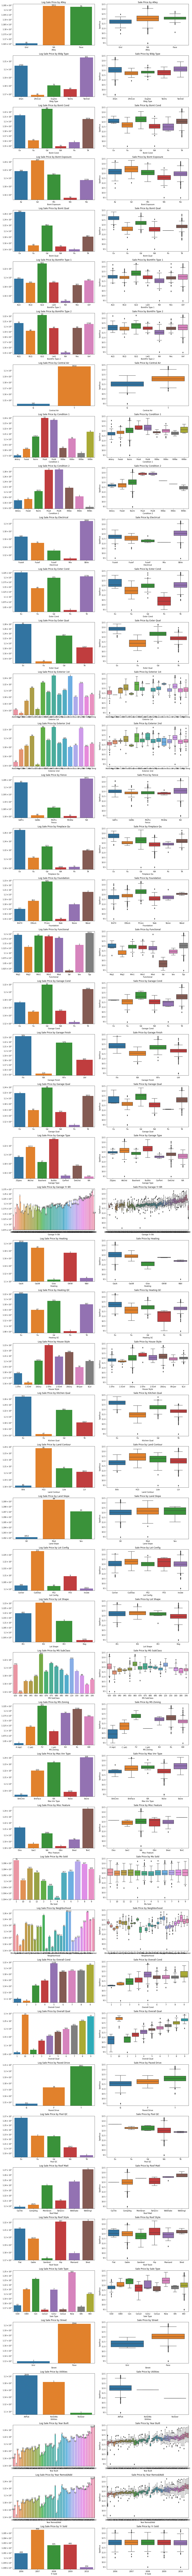

In [33]:
f, axs = plt.subplots(cat_df.shape[1], 2, figsize=(15, 4*cat_df.shape[1]))
for i, c in enumerate(cat_df):
    # compute average SalePrice by groups in column `c`
    s = log_sale_price.groupby(cat_df[c]).mean().sort_index()
    # plot the outcome of the above as a bar plot
    sns.barplot(x=s.index, y=s.values, ax=axs[i][0], log=True)
    axs[i][0].set_title(f"Log Sale Price by {c}", fontsize=12)
    axs[i][0].tick_params(axis='x', which='major', labelsize=10)
    
    # label each bar of the above by the size of each group
    cnt = cat_df.value_counts(c)
    for bar, xl in zip(axs[i][0].patches, s.index):
        axs[i][0].annotate(cnt[xl], 
                           (bar.get_x() + bar.get_width()/2, bar.get_height()*1.0001),
                           ha='center', color='black', fontsize=10)
    
    # plot the boxplot of SalePrice 
    sns.boxplot(x=cat_df[c].sort_values(), y=log_sale_price, ax=axs[i][1]);
    axs[i][1].set_title(f"Sale Price by {c}", fontsize=12)
    axs[i][1].tick_params(axis='x', which='major', labelsize=10);

f.tight_layout();

## EDA: `SalePrice` across `Yr Sold` by `Neighborhood`

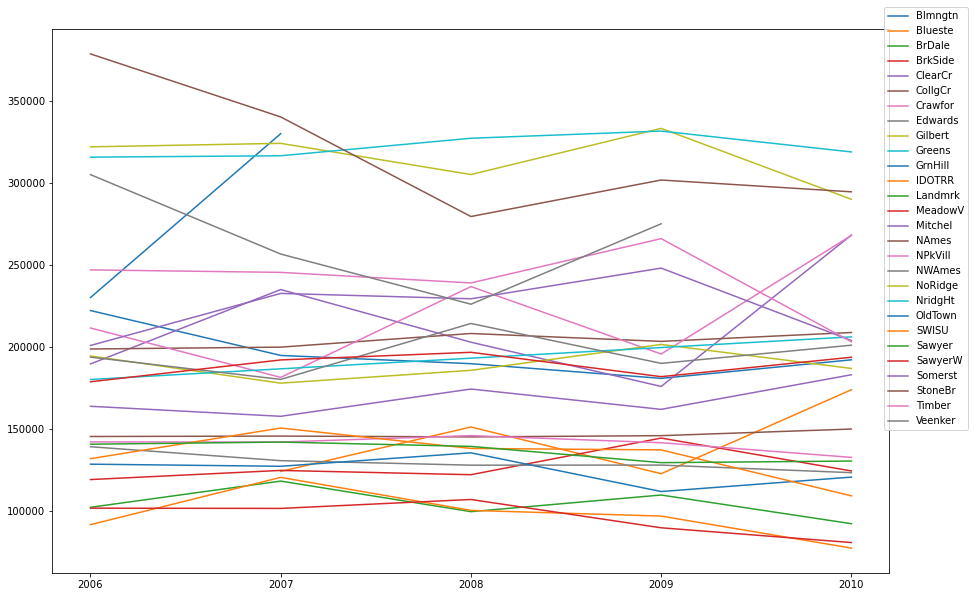

In [290]:
vv = df.groupby(['Yr Sold', 'Neighborhood'])['SalePrice'].mean().add(1).map(np.log).reset_index()

f, ax = plt.subplots(1, figsize=(15, 10))
for n, g in df.groupby('Neighborhood')[['Yr Sold', 'SalePrice']]:
    v = g.groupby('Yr Sold')['SalePrice'].mean()
    ax.plot(v.index, v.values, label=n)
ax.legend(bbox_to_anchor=(1.1, 1.05));

In [299]:
pt = df.pivot_table('SalePrice', 'Neighborhood', 'Yr Sold', 'mean')

best_neighborhoods = pt.gt(250000).all(1).pipe(lambda x: x.index[x])
mid_level = pt.gt(250000).any(1).pipe(lambda x: x.index[x]).difference(best_neighborhoods)
#rest = pt.index.difference(mid_level).difference(best_neighborhoods)

## EDA: Adding/removing features

In [307]:
def add_features(df0):
    
    df = df0.copy()
    
    to_drop = ['Street', 'Utilities', 'BsmtFin Type 2', 'Fence', 'Land Slope', 'Misc Feature', 'Misc Val', 
               'Pool QC', 'Roof Matl', 'PID', 'House Style', 'Alley', 'Id', 'Fireplaces',
               'Exterior 1st', 'Exterior 2nd'
              ]
    df = df.drop(columns=to_drop)
    
    df['Best Neighborhoods'] = df['Neighborhood'].isin(best_neighborhoods)
    df['Mid-level Neighborhoods'] = df.pop('Neighborhood').isin(mid_level)
    
    df['Gd Bsmt Exposure'] = df.pop('Bsmt Exposure') == 'Gd'
    df['Has Ex or Gd Bsmt Qual'] = df.pop('Bsmt Qual').isin(['Ex', 'Gd'])
    df['Has GLQ BsmtFin Type 1'] = df.pop('BsmtFin Type 1') == 'GLQ'
    df['Has Ex or Gd Bsmt Cond'] = df.pop('Bsmt Cond').isin(['Ex', 'Gd'])

    df['Is 1Fam or Twnhs'] = df.pop('Bldg Type').isin(['1Fam', 'TwnhsE'])
    df['Has Central Air'] = df.pop('Central Air') == 'Y'
    
    df['Close to Positive Features 1'] = df.pop('Condition 1').str.startswith('Pos')
    df['Close to Positive Features 2'] = df.pop('Condition 2').str.startswith('Pos')

    df['Has SBrkr Electrical'] = df.pop('Electrical') == 'SBrkr'

    df['Has Ex or Gd Exter Qual'] = df.pop('Exter Qual').isin(['Gd', 'Ex'])
    df['Has Ex, Gd or TA Exter Cond'] = df.pop('Exter Cond').isin(['Ex', 'Gd', 'TA'])
    
    df['Has Ex, Gd or TA Fireplace Qu'] = df.pop('Fireplace Qu').isin(['Ex', 'Gd', 'TA'])

    df['Has Typ Functional'] = df.pop('Functional') == 'Typ'
    df['Has Concrete Foundation'] = df.pop('Foundation') == 'PConc'

    df['Has Finished Garage'] = df.pop('Garage Finish') == 'Fin'
    df['Has Ex, Gd or TA Garage Cond'] = df.pop('Garage Cond').isin(['Ex', 'Gd', 'TA'])
    df['Has Ex, Gd or TA Garage Qual'] = df.pop('Garage Qual').isin(['Ex', 'Gd', 'TA'])
    df['Has Attached or Builtin Garage'] = df.pop('Garage Type').isin(['Attchd', 'BuiltIn'])
    
    df['Has GasA Heating'] = df.pop('Heating') == 'GasA'
    df['Has Ex Heating QC'] = df.pop('Heating QC') == 'Ex'

    df['Has Ex or Gd Kitchen Qual'] = df.pop('Kitchen Qual').isin(['Ex', 'Gd'])

    df['Has HLS Land Contour'] = df.pop('Land Contour') == 'HLS'
    df['Has Reg Lot Shape'] = df.pop('Lot Shape') == 'Reg'
    df['Is CulDSac'] = df.pop('Lot Config') == 'CulDSac'
    
    df['Has Masonry Veneer'] = ~df.pop('Mas Vnr Type').isin(['NA', 'None'])
    
    df['Is Low Density'] = df.pop('MS Zoning').map({'RL': True, 'RM': False, 'FV': True, 'I (all)': False, 
                                                    'C (all)': False, 'A (agr)': False, 'RH': False})
    
    df['MS SubClass 020 or 060'] = df.pop('MS SubClass').isin(['020', '060'])

    df['Has >5 Overall Cond'] = df.pop('Overall Cond').astype(int) > 5
    df['Overall Qual'] = df['Overall Qual'].astype('int64')

    df['Has Paved Drive'] = df.pop('Paved Drive') == 'Y'
    
    df['Has Hip Roof'] = df.pop('Roof Style') == 'Hip'
    
    df['New Sale Type'] = df.pop('Sale Type') == 'New'
    
    df[['Bsmt Full Bath', 'Bsmt Half Bath']] = df[['Bsmt Full Bath', 'Bsmt Half Bath']].astype('int64')
    
    df.insert(0, 'Age', df.pop('Yr Sold').astype(int).where(lambda x: x > df['Year Built'].astype(int), df['Year Built'].astype(int)) - df.pop('Year Built').astype(int))
    
    return df.query('`Bsmt Full Bath` != 3 and `Bsmt Half Bath` != 2')

In [308]:
df1 = add_features(df)
test1 = add_features(test)

In [309]:
ohe_cols = [
    'Bsmt Full Bath', 'Bsmt Half Bath', 
    'Full Bath', 'Half Bath'
]
ohe_cols += df1.columns[df1.dtypes == 'object'].tolist()
bool_cols = df1.columns[df1.dtypes == 'bool'].tolist()
num_cols = df1.columns.drop(ohe_cols+bool_cols).tolist()

In [310]:
X = df1.join(df1[num_cols].add(1).apply(np.log).add_prefix('Log ')).drop(columns=df1[num_cols])
test1 = test1.join(test1[num_cols[:-1]].add(1).apply(np.log).add_prefix('Log ')).drop(columns=test1[num_cols[:-1]])

y = X.pop('Log SalePrice')
num_cols = [f'Log {x}' for x in num_cols]

## Model: Separate into `X` and `y`

In [311]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

## Model 0: Baseline

In [312]:
np.sqrt(metrics.mean_squared_error(pd.Series(np.exp(y_train.mean()), index=y_test.index), np.exp(y_test)))

89599.36643547844

# Model 1: Linear Regression

In [313]:
ct = ColumnTransformer([
    ('oh', OneHotEncoder(drop='first'), ohe_cols),
    ('sc', StandardScaler(), num_cols[:-1]),
    ('poly', PolynomialFeatures(include_bias=False), num_cols[:-1]),
], remainder='passthrough')


pipe = Pipeline([
    ('ct', ct),
    ('lr', LinearRegression())
])


pipe.fit(X_train, y_train)
print("Train RMSE =", np.sqrt(metrics.mean_squared_error(np.exp(y_train), np.exp(pipe.predict(X_train)))))
print("Test RMSE =", np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(pipe.predict(X_test)))))

Train RMSE = 22318.299669717213
Test RMSE = 30299.207892112976


In [314]:
pipe.fit(X, y)
out = pd.DataFrame({'SalePrice': np.exp(pipe.predict(test1)) - 1}, index=test['Id'])

In [216]:
out.to_csv('../datasets/final_output.csv')

## Model 1: Cross validation score

In [315]:
Z_train = ct.fit_transform(X_train)
Z_test = ct.transform(X_test)
cross_val_score(LinearRegression(), Z_train, y_train, cv=10).mean()

-1250037729673.4753

Linear Regression is overfit. Train RMSE is much higher than test MSE, which implies that the model has high variance. However, compared to the baseline, it is much better, so the bias is probably low, indicative of linear regressions.

## Model 2: Lasso

In [316]:
pipe = Pipeline([
    ('ct', ct),
    ('lasso_cv', LassoCV(cv=5, max_iter=10000))
])


pipe.fit(X_train, y_train)


print("Train RMSE =", np.sqrt(metrics.mean_squared_error(np.exp(y_train), np.exp(pipe.predict(X_train)))))
print("Test RMSE =", np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(pipe.predict(X_test)))))

Train RMSE = 31365.805793539144
Test RMSE = 30346.008709673963


In [317]:
print("R2 score =", metrics.r2_score(y_test, pipe.predict(X_test)))

R2 score = 0.860603126683999


The train RMSE worsened to the point where it's worse than the test RMSE. It probably needs more tuning.

## Model 3: Grid Search LassoCV

In [318]:
pgrid = {
    'ct__poly__degree': [1, 2],
    'lasso_cv__n_alphas': np.arange(20, 41, 4)
}

gs = GridSearchCV(estimator=pipe, param_grid=pgrid, cv=5, scoring='neg_mean_squared_error', error_score='raise')
gs.fit(X_train, y_train)

gs.best_params_

{'ct__poly__degree': 1, 'lasso_cv__n_alphas': 24}

In [319]:
print("Train RMSE =", np.sqrt(metrics.mean_squared_error(np.exp(y_train), np.exp(gs.predict(X_train)))))
print("Test RMSE = ", np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(gs.predict(X_test)))))

Train RMSE = 27413.325255864227
Test RMSE =  30117.51138502497


In [320]:
print("R2 score =", metrics.r2_score(y_test, gs.predict(X_test)))

R2 score = 0.8717609835787382


Even with grid search, the test score didn't get better that the one in Model 1.

In [223]:
pd.DataFrame({'SalePrice': np.exp(gs.predict(test1))-1}, index=test['Id']).to_csv('../datasets/gs_lasso.csv')

## Model 4: Ridge

In [224]:
alphas = np.linspace(30, 40, 10)

Z_train = ct.fit_transform(X_train)
Z_test = ct.transform(X_test)

ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error').fit(Z_train, y_train);

print("Train RMSE =", np.sqrt(metrics.mean_squared_error(np.exp(y_train), np.exp(ridge_cv.predict(Z_train)))))
print("Test RMSE =", np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(ridge_cv.predict(Z_test)))))

Train RMSE = 26532.43043776634
Test RMSE = 23645.635746493306


In [225]:
print("R2 score =", metrics.r2_score(y_test, ridge_cv.predict(Z_test)))

R2 score = 0.8987465453380725


In [226]:
out_r = pd.DataFrame({'SalePrice': np.exp(ridge_cv.predict(ct.transform(test1))) - 1}, index=test['Id'])
out_r.to_csv('../datasets/ridge_cv.csv')

## Model 5: (Ridge + Lasso) / 2

In [228]:
out_rl = pd.read_csv('../datasets/gs_lasso.csv', index_col=[0]).add(pd.read_csv('../datasets/ridge_cv.csv', index_col=[0])).div(2)
out_rl.to_csv('../datasets/ridge_lasso.csv')

## Best Model Fitting and Evaluation

In [55]:
y_pred = ridge_cv.predict(Z_test)
resids = y_test - y_pred

In [56]:
# Independence = Assumed
# probably not true because colleges you apply to are not independent of each other

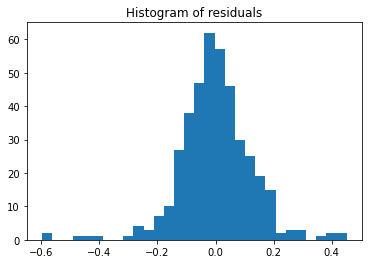

In [57]:
# Normality: has an outlier but otherwise looks OK

plt.hist(resids, bins=30);
plt.title('Histogram of residuals');
# fine

The residuals does not look normally distributed.

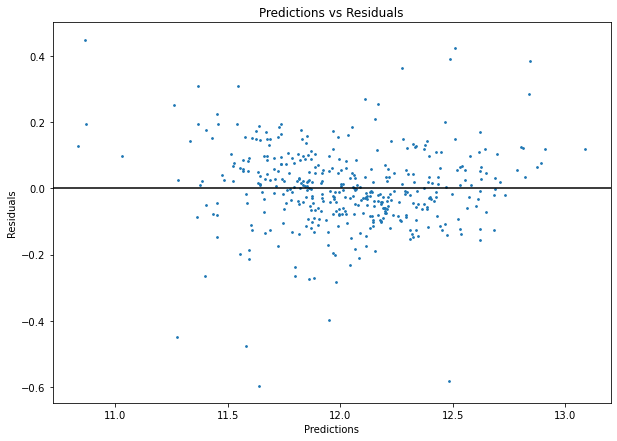

In [58]:
f, ax = plt.subplots(1, 1, figsize=(10,7))
ax.scatter(y_pred, resids, s=3)
ax.axhline(0, color='black')
ax.set_xlabel('Predictions')
ax.set_ylabel('Residuals')
ax.set_title('Predictions vs Residuals');

Linearity seems to be satisfied as there doesn't seem to be any specific pattern to the residuals. Equal variance also looks fine, because the magnitude of residuals doesn't depend on the magnitude of predictions.

In [82]:
ridge_coefs = pd.Series(ridge_cv.coef_, index=ct.get_feature_names_out())

In [161]:
d = {
    'oh__Neighborhood_NridgHt': 'Neighborhood: Northridge Heights',
    'remainder__Has Ex, Gd or TA Exter Cond': 'Has above average material on the exterior',
    'remainder__Is Low Density': 'Is in a residential and low density zone',
    'oh__Neighborhood_Edwards': 'Neighborhood: Edwards',
    'remainder__Has >5 Overall Cond': 'The overall condition of the house is above average',
    'remainder__Gd Bsmt Exposure': 'The basement has good exposure to walkout or garden level walls',
    'remainder__Has Central Air': 'Has central air conditioning',
    'remainder__Has Ex, Gd or TA Garage Cond': 'The garage condition is above average',
    'oh__Neighborhood_IDOTRR': 'Neighborhood: Iowa DOT and Rail Road',
    'oh__Neighborhood_Crawfor': 'Neighborhood: Crawford'
}
most_impactful_10 = ridge_coefs.pipe(lambda x: x[x.abs().sort_values(ascending=False).iloc[:10].index]).map(np.exp).sub(1).mul(100)
most_impactful_10.index = most_impactful_10.index.map(d)

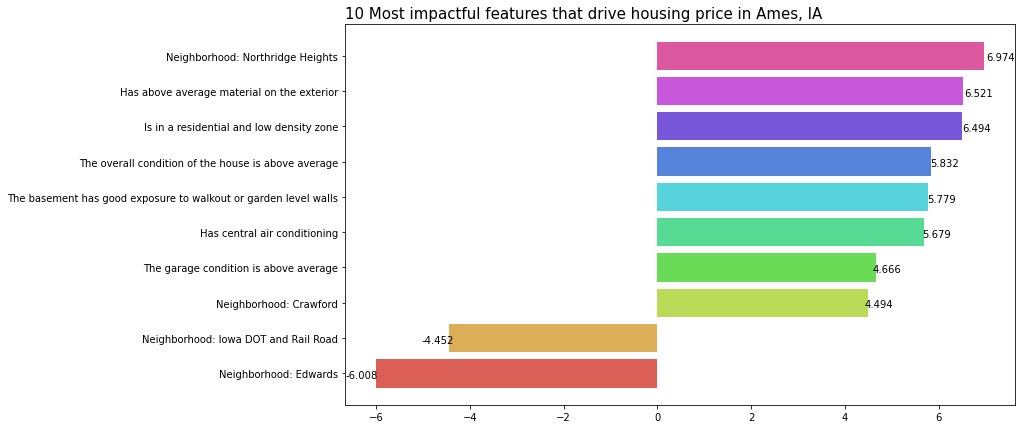

In [162]:
f, ax = plt.subplots(1, figsize=(12,7))
s = most_impactful_10.sort_values()
cmap = sns.color_palette("hls", 10)
ax.barh(width=s.values, y=s.index, color=cmap)
for i, bar in enumerate(ax.patches):
    x_adj = bar.get_x() + bar.get_width()*1.05
    ax.annotate(round(bar.get_width(), 3), 
                (x_adj, bar.get_y() + bar.get_height()/3),
                ha='center', color='black', fontsize=10);
ax.set_title('10 Most impactful features that drive housing price in Ames, IA', loc='left', fontsize=15)
f.savefig('../images/coefs.png', transparent=True, bbox_inches="tight");

In [154]:
d2 = dict(
    zip(s2.index, [
        'Lot Frontage^2',
        'Overall Quality x Type 1 Basement Area',
        'Total Basement Area x Ground Living Area',
        'Total Rooms x Garage Area',
        'Lot Frontage vs Overall Quality',
        'Lot Frontage',
        'Overall Quality x Ground Living Area',
        'Type 1 Basement Area',
        'Ground Living Area^2',
        'Overall Quality x Masonry Veneer Area'])
)

numeric_features = ridge_coefs[[x for x in ridge_coefs.index if 'sc_' in x or 'poly_' in x]]
s2 = numeric_features.pipe(lambda x: x[x.abs().sort_values(ascending=False).iloc[:10].index]).sort_values()
s2.index = s2.index.map(d2)

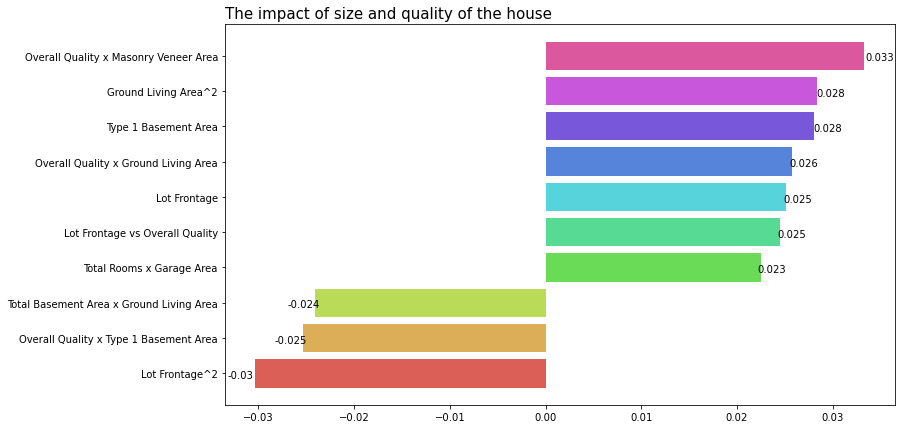

In [157]:
f2, ax = plt.subplots(1, figsize=(12,7))
cmap = sns.color_palette("hls", 10)
ax.barh(width=s2.values, y=s2.index, color=cmap)
for i, bar in enumerate(ax.patches):
    x_adj = bar.get_x() + bar.get_width()*1.05
    ax.annotate(round(bar.get_width(), 3), 
                (x_adj, bar.get_y() + bar.get_height()/3),
                ha='center', color='black', fontsize=10);
ax.set_title('The impact of size and quality of the house', loc='left', fontsize=15);
f2.savefig('../images/coefs_numer.png', transparent=True, bbox_inches="tight")

----

# Appendix

In [ ]:
# ordinal_cols = df.select_dtypes('number').pipe(lambda x: x.columns[x.nunique() < 15])
# number_cols = [c for c in df.columns if c not in object_cols and c not in cat_cols and c not in ordinal_cols][2:-1]

In [ ]:
# bsmtfin_sf_1 = []
# total_bsmt_sf = []

# for i in np.random.randint(0, 10000, size=1000):
#     X = df[['BsmtFin SF 1']].add(0.000001).apply(np.log)
#     y = df['SalePrice'].map(np.log)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
#     lr = LinearRegression().fit(X_train, y_train)
#     scorer = metrics.make_scorer(lambda x,y: np.sqrt(metrics.mean_squared_error(x, y)))

#     bsmtfin_sf_1.append([cross_val_score(lr, X_train, y_train, scoring=scorer).mean(), 
#                          np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test)))])

#     X = df[['Total Bsmt SF']].add(0.000001).apply(np.log)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
#     lr = LinearRegression().fit(X_train, y_train)

#     total_bsmt_sf.append([cross_val_score(lr, X_train, y_train, scoring=scorer).mean(), 
#                           np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test)))])

# np.mean(bsmtfin_sf_1, axis=0), np.mean(total_bsmt_sf, axis=0)

Looking at the pairplots, it seems some of our features move together. For example, `Log Total Flr Area` moves together with `Log Total Bsmt Area`. Will have to look into it when I build the model.

In [652]:
# sns.pairplot(df[['Total Bsmt SF', 'Gr Liv Area', 'Garage Area', 'SalePrice']], corner=True);

In [653]:
# df = df.join(df[['Total Bsmt SF', 'Total Flr Area', 'Garage Area', 'SalePrice']].add(0.0000001).apply(np.log).add_prefix('Log '))

In [ ]:
## EDA: Histograms of numeric columns

In [ ]:
# f, axs = plt.subplots(1, 2, figsize=(14,5))

# for i, x in enumerate([df['SalePrice'], df['Log SalePrice']]):
#     axs[i].hist(x, bins=100)

# axs[0].set_title('Distribution of Sale Price')
# axs[1].set_title('Distribution of Log Sale Price');

In [ ]:
# f, axs = plt.subplots(20, 3, figsize=(15, 80))
# for i, cs in enumerate(np.r_[ordinal_cols, cat_cols, object_cols[:-1]].reshape(20, 3)):
#     for j, c in enumerate(cs):
#         s = df.groupby(c)['SalePrice'].mean()
#         sns.barplot(x=s.index, y=s.values, ax=axs[i][j])
#         axs[i][j].set_title(f"Sale Price by {c}", fontsize=12)
#         axs[i][j].tick_params(axis='x', which='major', labelsize=10)

#         cnt = df.value_counts(c)
#         for bar, xl in zip(axs[i][j].patches, s.index):
#             axs[i][j].annotate(cnt[xl], 
#                                (bar.get_x() + bar.get_width()/2, bar.get_height()*1.01),
#                                ha='center', color='black', fontsize=10)

# f.tight_layout();

In [ ]:
# f, axs = plt.subplots(20, 3, figsize=(15, 80))
# for i, cs in enumerate(np.r_[ordinal_cols, cat_cols, object_cols[:-1]].reshape(20, 3)):
#     for j, c in enumerate(cs):
#         sns.boxplot(data=df, x=c, y='SalePrice', ax=axs[i][j]);
#         axs[i][j].set_title(f"Sale Price by {c}", fontsize=12)
#         axs[i][j].tick_params(axis='x', which='major', labelsize=10);
# f.tight_layout();

In [ ]:
# f, axs = plt.subplots(60, 2, figsize=(15, 200))
# for i, c in enumerate(np.r_[ordinal_cols, cat_cols, object_cols]):
#     s = df.groupby(c)['Log SalePrice'].mean()
#     sns.barplot(x=s.index, y=s.values, ax=axs[i][0])
#     axs[i][0].set_title(f"Log Sale Price by {c}", fontsize=12)
#     axs[i][0].tick_params(axis='x', which='major', labelsize=10)

#     cnt = df.value_counts(c)
#     for bar, xl in zip(axs[i][0].patches, s.index):
#         axs[i][0].annotate(cnt[xl], 
#                            (bar.get_x() + bar.get_width()/2, bar.get_height()*1.01),
#                            ha='center', color='black', fontsize=10)

#     sns.boxplot(data=df, x=c, y='Log SalePrice', ax=axs[i][1]);
#     axs[i][1].set_title(f"Log Sale Price by {c}", fontsize=12)
#     axs[i][1].tick_params(axis='x', which='major', labelsize=10);

# f.tight_layout();

In [ ]:
# def add_features(df):
    
#     df['Total Flr Area'] = df.filter(like='Flr SF').sum(1)
    
#     df['Has Multiple Full Baths'] = df['Full Bath'] > 1
#     df['Has Bsmt Full Bath'] = df['Bsmt Full Bath'] > 0
#     df['Has Half Bath'] = df['Half Bath'] > 0
#     df['Is Low Density'] = df['MS Zoning'].map({'RL': 1, 'RM': 0, 'FV': 1, 'I (all)': 0, 'C (all)': 0, 'A (agr)': 0, 'RH': 0})
#     df['Close to Positive Features 1'] = df['Condition 1'].str.startswith('Pos')
#     df['Close to Positive Features 2'] = df['Condition 2'].str.startswith('Pos')
#     df['Is CulDSac'] = df['Lot Config'] == 'CulDSac'
#     df['Is 1Fam or Twnhs'] = df['Bldg Type'].isin(['1Fam', 'TwnhsE'])
#     df['Has Central Air'] = df['Central Air'] == 'Y'
#     df['Has Paved Drive'] = df['Paved Drive'] == 'Y'
#     df['Has Hip Roof'] = df['Roof Style'] == 'Hip'
#     df['Has Masonry Veneer'] = ~df['Mas Vnr Type'].isin(['NA', 'None'])
#     df['Is in above avg Exter Cond'] = df['Exter Cond'].isin(['Ex', 'Gd', 'TA'])
#     df['Has Concrete Foundation'] = df['Foundation'] == 'PConc'
#     df['Has very good Bsmt Qual'] = df['Bsmt Qual'].isin(['Ex', 'Gd'])
#     df['Has GasA Heating'] = df['Heating'] == 'GasA'
#     df['Has excellent Heating QC'] = df['Heating QC'] == 'Ex'
#     df['Has SBrkr Heating'] = df['Electrical'] == 'SBrkr'
#     df['Has Attached or Builtin Garage'] = df['Garage Type'].isin(['Attchd', 'BuiltIn'])
#     df['Has Ex or Gd Exter Qual'] = df['Exter Qual'].isin(['Gd', 'Ex'])
#     df['Has Ex, Gd or TA Fireplace Qu'] = df['Fireplace Qu'].isin(['Ex', 'Gd', 'TA'])
#     df['MS SubClass 020 or 060'] = df['MS SubClass'].isin(['020', '060'])

#     df['Gd Bsmt Exposure'] = df['Bsmt Exposure'] == 'Gd'
#     df['Overall Qual'] = np.where(df['Overall Qual'] < 7, 0, df['Overall Qual'])
#     df['1 Ex Kitchen'] = df['Kitchen Qual'].eq('Ex') * df['Kitchen AbvGr'].eq(1)
#     df['Has Finished Garage'] = df['Garage Finish'].isin(['NA', 'Unf'])

#     df['Has Typ Functional'] = df['Functional'] == 'Typ'
#     df['Has GLQ BsmtFin Type 1'] = df['BsmtFin Type 1'] == 'GLQ'
    
#     df = df.query("20_000 < SalePrice < 580_000") if 'SalePrice' in df else df
    

#     features = ['Total Flr Area', 
#      'Garage Area', 
#      'TotRms AbvGrd',  # quadratic
#      'Has Multiple Full Baths',
#      'Has Bsmt Full Bath', 
#      'Has Half Bath', 
#      'Is Low Density', 
#      'Close to Positive Features 1',
#      'Close to Positive Features 2',
#      'Is CulDSac', 
#      'Is 1Fam or Twnhs',
#      'Has Central Air', 
#      'Has Paved Drive', 
#      'Has Hip Roof',
#      'Has Masonry Veneer', 
#      'Is in above avg Exter Cond',
#      'Has Concrete Foundation', 
#      'Has very good Bsmt Qual',
#      'Has GasA Heating', 
#      'Has excellent Heating QC', 
#      'Has SBrkr Heating',
#      'Has Attached or Builtin Garage', 
#      'Has Ex or Gd Exter Qual', 
#      'Has Ex, Gd or TA Fireplace Qu', 
#      'MS SubClass 020 or 060',
#      'Gd Bsmt Exposure', 
#      'Has Finished Garage',

#                 'Overall Qual', 'Neighborhood', 'Exterior 1st', 'Exterior 2nd', 'Sale Type'

#                ]

#     to_dummies = ['Overall Qual', 'Neighborhood', 
#                   'Exterior 1st', 'Exterior 2nd', 'Sale Type'
#                  ]
    
#     X_ = pd.get_dummies(data=df[features], columns=to_dummies, drop_first=True)
#     return X_

In [ ]:
# target = ['SalePrice']

# X_train = add_features(df)
# X_test = add_features(test)
# y_train = df[target[0]]

In [ ]:
# X_train.update(X_train[X_train.columns[:3]].add(0.0000001).apply(np.log))
# X_test.update(X_test[X_test.columns[:3]].add(0.0000001).apply(np.log))

In [ ]:
# sc = StandardScaler()
# Z_train = sc.fit_transform(X_train)
# Z_test = sc.transform(X_test)

# lasso_cv = LassoCV(n_alphas=100, cv=5, random_state=0, max_iter=10000).fit(Z_train, y_train.map(np.log))
# print(lasso_cv.score(Z_train, y_train.map(np.log)))

In [ ]:
# out = pd.DataFrame({'SalePrice': np.exp(lasso_cv.predict(Z_test))}, index=test['Id'])

In [ ]:
# out.head()

In [ ]:
# df['Has Multiple Full Baths'] = df['Full Bath'] > 1
# df['Has Bsmt Full Bath'] = df['Bsmt Full Bath'] > 0
# df['Has Half Bath'] = df['Half Bath'] > 0
# #df['Average Overall Cond'] = df['Overall Cond'] == 5
# #df['Has Gravel Alley'] = df['Alley'] == 'Grvl'
# df['Is Low Density'] = df['MS Zoning'].map({'RL': 1, 'RM': 0, 'FV': 1, 'I (all)': 0, 'C (all)': 0, 'A (agr)': 0, 'RH': 0})
# #df['Is Regular Shaped Property'] = df['Lot Shape'] == 'Reg'
# df['Close to Positive Features 1'] = df['Condition 1'].str.startswith('Pos')
# df['Close to Positive Features 2'] = df['Condition 2'].str.startswith('Pos')
# df['Is CulDSac'] = df['Lot Config'] == 'CulDSac'
# df['Is 1Fam or Twnhs'] = df['Bldg Type'].isin(['1Fam', 'TwnhsE'])
# df['Has Central Air'] = df['Central Air'] == 'Y'
# df['Has Paved Drive'] = df['Paved Drive'] == 'Y'
# df['Has Hip Roof'] = df['Roof Style'] == 'Hip'
# df['Has Masonry Veneer'] = ~df['Mas Vnr Type'].isin(['NA', 'None'])
# df['Is in above avg Exter Cond'] = df['Exter Cond'].isin(['Ex', 'Gd', 'TA'])
# df['Has Concrete Foundation'] = df['Foundation'] == 'PConc'
# df['Has very good Bsmt Qual'] = df['Bsmt Qual'].isin(['Ex', 'Gd'])
# df['Has GasA Heating'] = df['Heating'] == 'GasA'
# df['Has excellent Heating QC'] = df['Heating QC'] == 'Ex'
# df['Has SBrkr Heating'] = df['Electrical'] == 'SBrkr'
# df['Has Attached or Builtin Garage'] = df['Garage Type'].isin(['Attchd', 'BuiltIn'])
# #df['Has above avg Garage Qual'] = df['Garage Qual'].isin(['Gd', 'Ex', 'TA'])
# df['Has Ex or Gd Exter Qual'] = df['Exter Qual'].isin(['Gd', 'Ex'])
# #df['Is in Gd or TA Garage Cond'] = df['Garage Cond'].isin(['Gd', 'TA'])
# df['Has Ex, Gd or TA Fireplace Qu'] = df['Fireplace Qu'].isin(['Ex', 'Gd', 'TA'])
# df['MS SubClass 020 or 060'] = df['MS SubClass'].isin(['020', '060'])

# df['Gd Bsmt Exposure'] = df['Bsmt Exposure'] == 'Gd'
# df['Overall Qual'] = np.where(df['Overall Qual'] < 7, 0, df['Overall Qual'])

# df['Has one Kitchen'] = df['Kitchen AbvGr'] == 1

# features = ['Built Before 1983', 'Total Flr Area', 'Garage Area', 'Has Multiple Full Baths', 'Has Bsmt Full Bath',
#             'Has Half Bath', 'TotRms AbvGrd', 'Average Overall Cond', 'Overall Qual', 
#             'Has Gravel Alley', 'Is Low Density', 'Is Regular Shaped Property',  'Neighborhood', 'Close to Positive Features 1',
#             'Close to Positive Features 2', 'Is CulDSac', 'Is 1Fam or Twnhs', 'Has Central Air', 
#             'Has Paved Drive', 'Has Hip Roof', 'Has Masonry Veneer', 'Is in above avg Exter Cond',
#             'Has Concrete Foundation', 'Has very good Bsmt Qual', 'Has GasA Heating', 'Has excellent Heating QC',
#             'Has SBrkr Heating', 'Has Attached or Builtin Garage', 'Has above avg Garage Qual',
#             'MS SubClass 020 or 060',

#   #          'Has one Kitchen',
#             'Has Ex or Gd Exter Qual', 'Is in Gd or TA Garage Cond', 'Has Ex, Gd or TA Fireplace Qu', 'Gd Bsmt Exposure', 
            
#             'Exterior 1st',
#             'Exterior 2nd',
#             'BsmtFin Type 1',
#             'BsmtFin Type 2',
#    #         'Kitchen Qual', 
#             'Functional',
#             'Garage Finish',
#             'Sale Type'
#            ]
# log_features = ['Built Before 1983', 'Log Total Flr Area', 'Log Garage Area', 'Has Multiple Full Baths', 'Has Bsmt Full Bath',
#                 'Has Half Bath', 'TotRms AbvGrd', 'Average Overall Cond', 'Overall Qual', 
#                 'Has Gravel Alley', 'Is Low Density', 'Is Regular Shaped Property',  'Neighborhood', 'Close to Positive Features 1',
#                 'Close to Positive Features 1', 'Is CulDSac', 'Is 1Fam or Twnhs', 'Has Central Air', 
#                 'Has Paved Drive', 'Has Hip Roof', 'Has Masonry Veneer', 'Is in above avg Exter Cond',
#                 'Has Concrete Foundation', 'Has very good Bsmt Qual', 'Has GasA Heating', 'Has excellent Heating QC',
#                 'Has SBrkr Heating', 'Has Attached or Builtin Garage', 'Has above avg Garage Qual', 'Has Ex or Gd Exter Qual', 
#                 'Is in Gd or TA Garage Cond', 'Gd Bsmt Exposure', 
#             'MS SubClass 020 or 060',

#    #             'Has one Kitchen',
#             'Exterior 1st',
#             'Exterior 2nd',
#             'BsmtFin Type 1',
#             'BsmtFin Type 2',
# #            'Kitchen Qual', 
#             'Functional',
#             'Garage Finish',
#             'Sale Type'
#                ]

# to_dummies = ['Overall Qual', 'Neighborhood', 'Exterior 1st', 'Exterior 2nd',
#             'BsmtFin Type 1',
#             'BsmtFin Type 2',
#     #        'Kitchen Qual', 
#             'Functional',
#             'Garage Finish',
#             'Sale Type'
#              ]

# target = ['SalePrice']
# log_target = ['Log SalePrice']



In [ ]:
# X = pd.get_dummies(data=df[log_features + log_target], columns=to_dummies, drop_first=True)
# y = X.pop('Log SalePrice')

In [ ]:
# sc = StandardScaler()
# Z_train = sc.fit_transform(X_train)
# Z_test = sc.transform(X_test)

# lasso_cv = LassoCV(n_alphas=100, cv=5, random_state=2022, max_iter=10000).fit(Z_train, y_train)
# print(lasso_cv.score(Z_train, y_train))
# print(lasso_cv.score(Z_test, y_test))

In [ ]:
# X = pd.get_dummies(data=df[features + target], columns=to_dummies, drop_first=True)
# y = X.pop('SalePrice')
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2022, train_size=0.75)

# sc = StandardScaler()
# Z_train = sc.fit_transform(X_train)
# Z_test = sc.transform(X_test)

# lasso_cv = LassoCV(n_alphas=100, cv=5, random_state=0, max_iter=10000).fit(Z_train, y_train)
# print(lasso_cv.score(Z_train, y_train))
# print(lasso_cv.score(Z_test, y_test))

In [ ]:
# ct = ColumnTransformer([
#     ('oh', OneHotEncoder(drop='first'), ohe_cols),
#     ('poly', PolynomialFeatures(include_bias=False), num_cols[:-1]),
#     ('sc', StandardScaler(), num_cols[:-1]),
# ], remainder='passthrough')


# pipe = Pipeline([
#     ('ct', ct),
#     ('lasso', Lasso())
# ])


# pgrid = {
#     'ct__poly__degree': [1, 2],
#     'lasso__alpha': np.logspace(-4, -1, 10) 
# }

# gs = GridSearchCV(estimator=pipe, param_grid=pgrid, cv=5, scoring='neg_mean_squared_error', error_score='raise')
# gs.fit(X_train, y_train)

# gs.best_score_